# SD212: Graph mining

## Project

### Title: How can we make good recommendations to a fellow anime watcher?

### Students: CHHY Laurent, MAI Huu Tan

The objective of this project is to learn how to extract useful information from graph data. 

Your task is the following:
* build your own graph from real data
* specify the problem(s) you would like to solve
* provide a solution
* visualize the results

## Instructions

You can work in **teams of 2 or 3**.

Fill the following variable with the names of all students of this project separated by _:

In [2]:
name = 'CHHY_MAI'

You **must** use this name for the pickle file of your dataset and provide a link to this file:

In [3]:
# url to your dataset, to be modified
url = 'https://nextcloud.r2.enst.fr/nextcloud/index.php/s/RTGFHLrjsGQ4pqr'

Check the notebook ``my_dataset`` to generate a pickle file in appropriate format (``Bunch`` object).

You must use the following name for your notebook:

In [4]:
# name of your notebook
name + '.ipynb'

'CHHY_MAI.ipynb'

## Data

In [5]:
import pickle

In [6]:
# you need to download data first (see the above url)
#with open(name, 'br') as f:
#    dataset = pickle.load(f)

In [7]:
#dataset

Describe your data and how it has been collected (do not include the code used to extract data).

## Problem

Describe the problem you want to solve (be concise).

The problem we want to solve is that of recommendations. The question is as follows:
How can we make good recommendations to a fellow anime watcher?

## Solution

Describe your solution, including the code and a visualization of the results.

In [55]:
import numpy as np

from sknetwork.data import from_edge_list
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sknetwork.ranking import PageRank, top_k
from sknetwork.embedding import Spectral
from sknetwork.utils import get_neighbors
from sknetwork.hierarchy import Paris



import csv
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG

### Preprocessing

In [9]:
anime_df = pd.read_csv('data/anime.csv', header=0, encoding = 'ISO-8859-1')
anime_df["name"][0]

"b'Fullmetal Alchemist: Brotherhood'"

The titles are written incorrectly. We need to preprocess the data a little.

In [10]:
def rewrite_title(title):
    return title[2:-1]

anime_df["name"] = anime_df["name"].apply(rewrite_title)

anime_df

anime_id                                         name  \
0        5114             Fullmetal Alchemist: Brotherhood   
1       28977                              Gintama\xc2\xb0   
2        9253                                  Steins;Gate   
3       38524           Shingeki no Kyojin Season 3 Part 2   
4        9969                                     Gintama'   
..        ...                                          ...   
195      9617                                  K-On! Movie   
196     17389                           Kingdom 2nd Season   
197     22535                   Kiseijuu: Sei no Kakuritsu   
198     49909                     Kotarou wa Hitorigurashi   
199     37515  Made in Abyss Movie 2: Hourou Suru Tasogare   

                                                 genre   type  episodes  \
0          ['Action', 'Adventure', 'Drama', 'Fantasy']     TV      64.0   
1                       ['Action', 'Comedy', 'Sci-Fi']     TV      51.0   
2                      ['Drama', 'Sci-Fi', 'Suspense']     TV      24.0   
3                                  ['Action', 'Drama']     TV      10.0   
4                       ['Action', 'Comedy', 'Sci-Fi']     TV      51.0   
..                                                 ...    ...       ...   
195                        ['Comedy', 'Slice of Life']  Movie       1.0   
196                                         ['Action']     TV      39.0   
197                     ['Action', 'Horror', 'Sci-Fi']     TV      24.0   
198                        ['Comedy', 'Slice of Life']    ONA      10.0   
199  ['Adventure', 'Drama', 'Fantasy', 'Mystery', '...  Movie       1.0   

     rating  members  
0      9.14  2893493  
1      9.08   536990  
2      9.08  2245646  
3      9.07  1847582  
4      9.05   473413  
..      ...      ...  
195    8.35   294502  
196    8.35   103013  
197    8.35  1636938  
198    8.34    76773  
199    8.35    94758  

[200 rows x 7 columns]

In [11]:
rating_df = pd.read_csv('data/rating.csv', header=0, encoding = 'ISO-8859-1')
rating_df

username  anime_id  rating
0             Lachawla         1      -1
1                Dubba         1       9
2              epicene         1      10
3            Effloress         1      -1
4        JeSuisGarrick         1      -1
...                ...       ...     ...
74395       bxrrylatte      9969      -1
74396       KarolusZan      9969      -1
74397           bilwor      9969      -1
74398  JezusAntychryst      9969      -1
74399       Ragnarok82      9969      -1

[74400 rows x 3 columns]

In [12]:
def check_sanity():
    L1 = set(rating_df['anime_id'])
    L2 = set(anime_df['anime_id'])
    print(len(L1))
    print(len(L2))
    for x in L2:
        if x not in L1:
            print(x)

check_sanity()

199
200
44042


It turns out that one of the animes has no ratings. This is a problem with the Jikan API used to scrape user updates, but we will choose to deliberately ignore that.

In [13]:
# The -1 in the ratings mean that the user has not rated the anime.
rating_df = rating_df[rating_df['rating'] >0]

We can plot the ratings to have an idea of the rating distribution.

Text(0.5, 1.0, 'Rating Distribution')

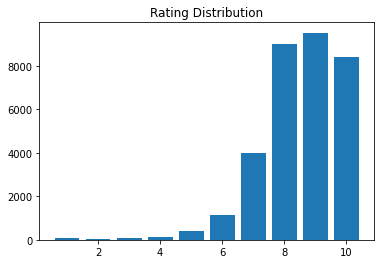

In [14]:
from collections import Counter

#count ratings
rating_count = Counter(rating_df['rating'])
#plot ratings
plt.bar(rating_count.keys(), rating_count.values())
plt.title("Rating Distribution")

Since the genres are incorrectly inputed as a string, we will parse the string to extract the genres of each anime.

In [15]:
rating_numpy = rating_df.to_numpy()


In [16]:
def parse_list_str(str):
    list = str[1:-1].replace("'", "").split(",")
    for i in range(len(list)):
        list[i] = list[i].strip()
    return list
parse_list_str(anime_df["genre"][0])

['Action', 'Adventure', 'Drama', 'Fantasy']

In [17]:
anime_ids = np.unique(rating_numpy[:, 1])
#retrieve anime names from anime_df
anime_names = []
anime_genres = []
for anime_id in anime_ids:
    name = anime_df[anime_df['anime_id'] == anime_id]['name'].values
    genre_str = anime_df[anime_df['anime_id'] == anime_id]['genre'].values
    genre_list = parse_list_str(genre_str[0])
    anime_genres.append(genre_list)
    anime_names.append(name[0])
anime_names = np.array(anime_names)
anime_genres = np.array(anime_genres, dtype=object)



In [18]:
# For example, the genres of Cowboy Bebop are Action, Sci-Fi.
anime_genres[anime_names=="Cowboy Bebop"]

array([list(['Action', 'Sci-Fi'])], dtype=object)

Then, we can one-hot-encode those genres to facilitate the graph mining methods later.

In [19]:
#one_hot_encode genres
def one_hot_genres(anime_genres):
    all_genres = np.unique(np.concatenate(anime_genres))
    one_hot_genres = []
    for genre_list in anime_genres:
        one_hot_genre = np.zeros(len(all_genres))
        for genre in genre_list:
            one_hot_genre[all_genres == genre] = 1
        one_hot_genres.append(one_hot_genre)
    return np.array(one_hot_genres), all_genres

Finally, to have the animes on the left side and the users on the right side of the bipartite graph, we can swap the columns.

In [20]:
# swapping columns to have the anime_id as the first column
rating_numpy = rating_numpy[:, [1, 0, 2]]

Now is a good time to build the graph.

In [21]:
# Now we build the graph
graph = from_edge_list(rating_numpy,bipartite = True)

In [22]:
biadjacency = graph.biadjacency
names = np.array(anime_names)
labels, label_names = one_hot_genres(anime_genres)

In [23]:
image = svg_bigraph(biadjacency, names, width=1000, height=1000, scale = 200)
SVG(image)

In [24]:
biadjacency.shape

(199, 16835)

## Pagerank

We can attempt to use personalized PageRank to get the most popular movies of each genre.

Since we already have the top animes in order in the dataframe, we can see if they match the prediction given by a PageRank.

In [25]:
pagerank = PageRank()

In [26]:
# Get the good positive ratings.
positive = biadjacency >= 1

In [27]:
# Top 20 animes according to pagerank
scores = pagerank.fit_transform(positive)
names[top_k(scores, 20)]

array(['Kimetsu no Yaiba Movie: Mugen Ressha-hen', 'Koe no Katachi',
       'Sen to Chihiro no Kamikakushi', 'Howl no Ugoku Shiro',
       'Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou',
       'Yakusoku no Neverland', 'Kimi no Na wa.', 'Shingeki no Kyojin',
       'One Punch Man', 'Shingeki no Kyojin Season 3',
       'Shingeki no Kyojin: The Final Season Part 2',
       'Shingeki no Kyojin Season 2',
       'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou',
       'Death Note', 'Evangelion: 3.0+1.0 Thrice Upon a Time',
       'Mononoke Hime',
       'Steins;Gate Movie: Fuka Ryouiki no D\\xc3\\xa9j\\xc3\\xa0 vu',
       'Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai',
       'Neon Genesis Evangelion: The End of Evangelion',
       'Made in Abyss Movie 3: Fukaki Tamashii no Reimei'], dtype='<U69')

In [28]:
anime_df[:10]

anime_id                                name  \
0      5114    Fullmetal Alchemist: Brotherhood   
1     28977                     Gintama\xc2\xb0   
2      9253                         Steins;Gate   
3     38524  Shingeki no Kyojin Season 3 Part 2   
4      9969                            Gintama'   
5     39486                  Gintama: The Final   
6     11061              Hunter x Hunter (2011)   
7     15417                 Gintama': Enchousen   
8     42938            Fruits Basket: The Final   
9       820                Ginga Eiyuu Densetsu   

                                         genre   type  episodes  rating  \
0  ['Action', 'Adventure', 'Drama', 'Fantasy']     TV      64.0    9.14   
1               ['Action', 'Comedy', 'Sci-Fi']     TV      51.0    9.08   
2              ['Drama', 'Sci-Fi', 'Suspense']     TV      24.0    9.08   
3                          ['Action', 'Drama']     TV      10.0    9.07   
4               ['Action', 'Comedy', 'Sci-Fi']     TV      51.0    9.05   
5      ['Action', 'Comedy', 'Drama', 'Sci-Fi']  Movie       1.0    9.05   
6           ['Action', 'Adventure', 'Fantasy']     TV     148.0    9.05   
7               ['Action', 'Comedy', 'Sci-Fi']     TV      13.0    9.04   
8         ['Drama', 'Romance', 'Supernatural']     TV      13.0    9.03   
9                          ['Drama', 'Sci-Fi']    OVA     110.0    9.03   

   members  
0  2893493  
1   536990  
2  2245646  
3  1847582  
4   473413  
5   103872  
6  2382619  
7   282329  
8   350828  
9   280661

The top ranking doesn't match at all.

This can be explained by the fact that while the rating entries were sampled from recent entries, many of the top animes are rather old.

In [29]:
# number of movies per genre
n_selection = 10

# Top 10 animes for each genre
# selection using pagerank
selection = []
for label in np.arange(len(label_names)):
    ppr = pagerank.fit_transform(positive, seeds=labels[:, label])
    scores = ppr * labels[:, label]
    selection.append(top_k(scores, n_selection))
selection = np.array(selection)

for label, name_label in enumerate(label_names):
    print('---')
    print(label, name_label)
    # Sometimes the amount of animes of the specified genres is less than n_selection.
    p = len(anime_df[anime_df["genre"].str.contains(name_label)])
    n = np.minimum(n_selection, p)
    
    print(names[selection[label, :n]])

---
0 
['Paripi Koumei' 'Shoujo\\xe2\\x98\\x86Kageki Revue Starlight Movie'
 'Yoru ni Kakeru' 'Kizumonogatari I: Tekketsu-hen'
 'Haikyuu!!: Karasuno Koukou vs. Shiratorizawa Gakuen Koukou'
 'Saenai Heroine no Sodatekata Fine' 'Zoku Owarimonogatari'
 'Mob Psycho 100' 'Grand Blue' 'Mo Dao Zu Shi']
---
1 Action
['One Piece' 'Wu Liuqi Zhi Xuanwu Guo Pian'
 'Gintama Movie 1: Shinyaku Benizakura-hen' 'Kingdom 3rd Season'
 'Shingeki no Kyojin: The Final Season Part 2' 'Gintama: The Semi-Final'
 'Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare'
 'Kingdom 2nd Season' 'Gintama' 'Gintama: The Final']
---
2 Adventure
['One Piece' 'Wu Liuqi Zhi Xuanwu Guo Pian'
 'Made in Abyss Movie 3: Fukaki Tamashii no Reimei'
 'Mushishi Zoku Shou: Odoro no Michi'
 'Made in Abyss Movie 2: Hourou Suru Tasogare'
 'Kaze no Tani no Nausica\\xc3\\xa4' 'Mushishi: Hihamukage'
 'Tian Guan Ci Fu' 'Mushishi Zoku Shou: Suzu no Shizuku' 'Ousama Ranking']
---
3 Avant Garde
['Perfect Blue' 'Neon Genesis Evangelion: The E

In [30]:
anime_df[anime_df["genre"] == '[]']

anime_id                                            name genre   type  \
92      40664  Shoujo\xe2\x98\x86Kageki Revue Starlight Movie    []  Movie   
152     48653                                  Yoru ni Kakeru    []  Music   
176      9260                  Kizumonogatari I: Tekketsu-hen    []  Movie   
177     50380                                   Paripi Koumei    []     TV   

     episodes  rating  members  
92        1.0    8.56    10378  
152       1.0    8.42    13231  
176       1.0    8.38   470424  
177      12.0    8.38   150645

Now, we can recommend new animes by either presenting shows similar to one anime in particular or by taking into account what a user has already rated. Let's try the two methods.

In [36]:
target = {id: name for id,name in enumerate(names) if "Kono Subarashii Sekai ni Shukufuku wo!" in name}
target

{144: 'Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu'}

In [37]:
scores_ppr = pagerank.fit_transform(positive, seeds={144:1})

In [38]:
names[top_k(scores_ppr - scores,10)]

array(['Kono Subarashii Sekai ni Shukufuku wo! Movie: Kurenai Densetsu',
       'Seishun Buta Yarou wa Yumemiru Shoujo no Yume wo Minai',
       'Nichijou', 'Made in Abyss Movie 3: Fukaki Tamashii no Reimei',
       'Violet Evergarden Movie', 'Fate/Zero 2nd Season',
       "Fate/stay night Movie: Heaven's Feel - II. Lost Butterfly",
       'Great Teacher Onizuka', 'Saiki Kusuo no \\xce\\xa8-nan 2',
       'Koe no Katachi'], dtype='<U69')

In [47]:
targets = get_neighbors(positive, 75, transpose = True)

In [48]:
names[targets][:10]

array(['Cowboy Bebop', 'Howl no Ugoku Shiro', 'Shigatsu wa Kimi no Uso',
       'Koe no Katachi', 'Ansatsu Kyoushitsu 2nd Season',
       '3-gatsu no Lion', 'Saiki Kusuo no \\xce\\xa8-nan',
       'Violet Evergarden', 'Yakusoku no Neverland',
       'Fruits Basket 2nd Season'], dtype='<U69')

In [50]:
mask = np.zeros(len(names),dtype='bool')
mask[targets] = 1

In [51]:
scores_ppr = pagerank.fit_transform(positive, seeds=mask)

In [52]:
names[top_k((scores_ppr - scores)*(1-mask),10)]

array(['Kimi no Na wa.', 'Sen to Chihiro no Kamikakushi',
       'Shingeki no Kyojin Season 3', 'One Punch Man',
       'Shingeki no Kyojin Season 2', 'Shingeki no Kyojin',
       'Saiki Kusuo no \\xce\\xa8-nan 2', 'Kimetsu no Yaiba',
       'Shingeki no Kyojin Season 3 Part 2',
       'Violet Evergarden Gaiden: Eien to Jidou Shuki Ningyou'],
      dtype='<U69')

In [56]:
paris = Paris()

In [66]:
animes = graph.names_row
users = graph.names_col

In [68]:
paris.fit(biadjacency)


Paris(weights='degree', reorder=True)

In [69]:
dendrogram_row = paris.dendrogram_row_
dendrogram_col = paris.dendrogram_col_

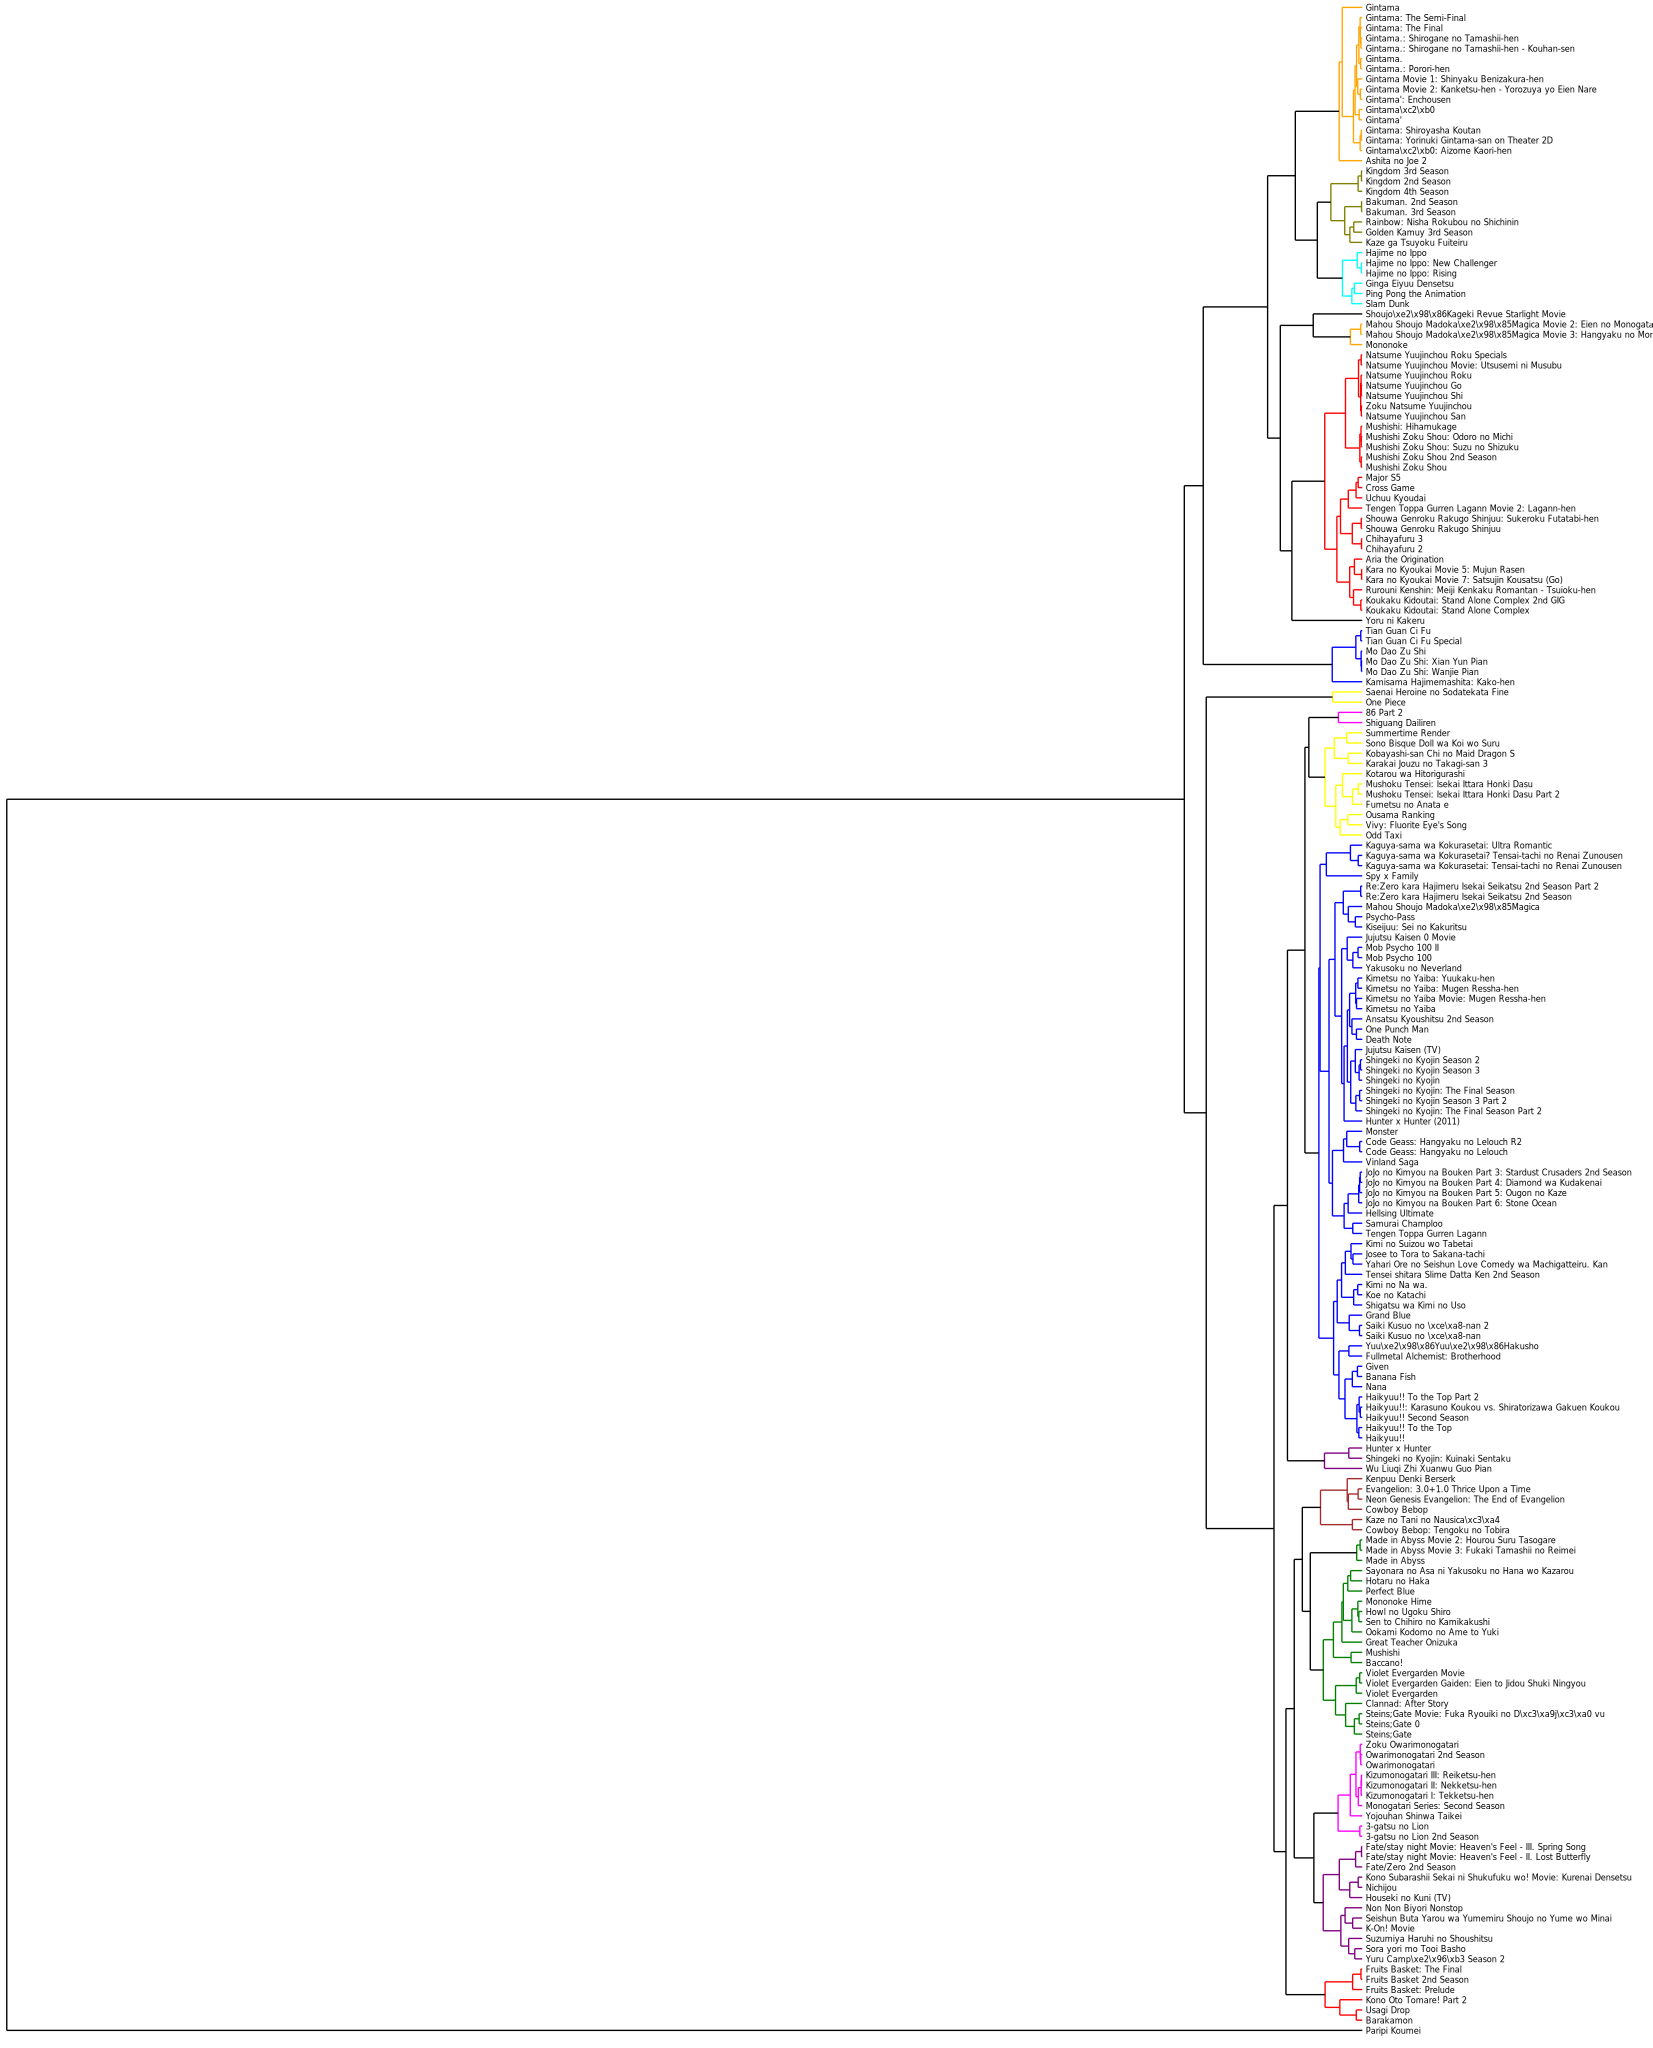

In [75]:
image = svg_dendrogram(dendrogram_row, names, rotate = True, width = 200, scale = 10, n_clusters = 20)
SVG(image)